In [1]:
import psycopg2
import pandas as pd
import mplfinance as mpf

In [2]:
import configparser
cfg=configparser.ConfigParser()
cfg.read('resources.cfg')

['resources.cfg']

The required parameters to connect to Redshift are:
+ host
+ port
+ dbname
+ user
+ password

The same as set in airflow connection variable.

In [3]:
conn = psycopg2.connect(**cfg['Redshift'])

query the index history value of 2022-03-03 in the scale of 5 minutes.

In [4]:
sql_command = """
select * 
from index 
    join index_history on index.id = index_history.index_id 
where index.name = 'TAIEX' 
    and index_history.scale = 5 
    and datetime between '2022-03-03' and '2022-03-04'
order by index_history.datetime
"""

In [5]:
cur = conn.cursor()
cur.execute(sql_command)
df = pd.DataFrame(cur.fetchall())

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,TAIEX,TW,1,5,2022-03-03 01:00:00,17867.60,17867.60,17867.60,17867.60,17867.600000,NaN
1,1,TAIEX,TW,1,5,2022-03-03 01:05:00,17932.15,18026.03,17932.15,17999.75,18005.540500,14.941853
2,1,TAIEX,TW,1,5,2022-03-03 01:10:00,18010.65,18012.56,17992.12,18000.68,18003.664833,4.311531
3,1,TAIEX,TW,1,5,2022-03-03 01:15:00,17986.74,17995.73,17960.87,17973.63,17979.172000,9.853270
4,1,TAIEX,TW,1,5,2022-03-03 01:20:00,17984.11,17993.24,17977.58,17977.58,17984.018667,4.216149


In [6]:
df = df.iloc[:, 5:10]
df.columns=['datetime', 'open', 'high', 'low', 'close']
df = df.astype({'datetime': 'datetime64', 'open': 'double', 'high': 'double', 'low': 'double', 'close': 'double'})
df = df.set_index('datetime')

df.head()

,open,high,low,close
datetime,,,,
2022-03-03 01:00:00,17867.60,17867.60,17867.60,17867.60
2022-03-03 01:05:00,17932.15,18026.03,17932.15,17999.75
2022-03-03 01:10:00,18010.65,18012.56,17992.12,18000.68
2022-03-03 01:15:00,17986.74,17995.73,17960.87,17973.63
2022-03-03 01:20:00,17984.11,17993.24,17977.58,17977.58


The most simple way to draw basic candle stick diagram is using [`mplfinance`](https://github.com/matplotlib/mplfinance) IMO.

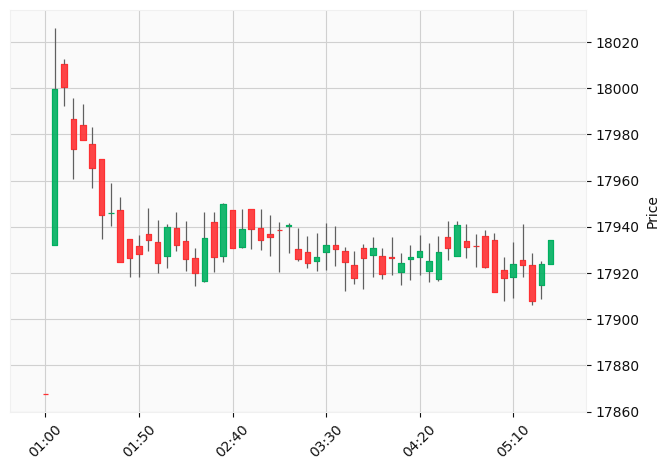

In [7]:
mpf.plot(df, type='candle', style='yahoo')

To query history data on 2022-03-07 of a derivative contract in 15 minutes scale, alone with volume.

In [8]:
sql_command2 = """
select ddh.datetime, ddh.price_open, ddh.price_high, ddh.price_low, ddh.price_close, ddh.volume 
from derivative d 
    join derivative_detail dd on dd.derivative_id = d.id 
    join derivative_detail_history ddh on ddh.derivative_detail_id = dd.id 
where d.name = 'TX' 
    and dd.expire_code = 'M' 
    and ddh.scale = 15 
    and ddh.datetime between '2022-03-07' and '2022-03-08'
order by ddh.datetime
"""

In [9]:
cur = conn.cursor()
cur.execute(sql_command2)
df = pd.DataFrame(cur.fetchall())

df.head()

,0,1,2,3,4,5
0,2022-03-07 00:45:00,17362.00,17363.00,17327.00,17353.00,3064
1,2022-03-07 01:00:00,17340.00,17405.00,17312.00,17358.00,25064
2,2022-03-07 01:15:00,17359.00,17385.00,17233.00,17239.00,42204
3,2022-03-07 01:30:00,17236.00,17252.00,17174.00,17205.00,29780
4,2022-03-07 01:45:00,17208.00,17242.00,17128.00,17130.00,28484


In [10]:
df.columns=['datetime', 'open', 'high', 'low', 'close', 'volume']
df = df.astype({'datetime': 'datetime64', 'open': 'double', 'high': 'double', 'low': 'double', 'close': 'double', 'volume': 'int'})
df = df.set_index('datetime')

df.head()

,open,high,low,close,volume
datetime,,,,,
2022-03-07 00:45:00,17362.0,17363.0,17327.0,17353.0,3064
2022-03-07 01:00:00,17340.0,17405.0,17312.0,17358.0,25064
2022-03-07 01:15:00,17359.0,17385.0,17233.0,17239.0,42204
2022-03-07 01:30:00,17236.0,17252.0,17174.0,17205.0,29780
2022-03-07 01:45:00,17208.0,17242.0,17128.0,17130.0,28484


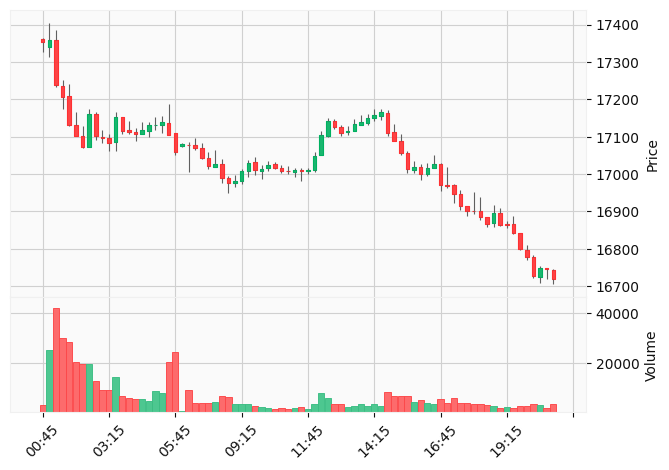

In [11]:
mpf.plot(df, type='candle', style='yahoo', volume=True)